In [1]:
%load_ext autoreload
from iqm.benchmarks.compressive_gst.compressive_gst import GSTConfiguration, CompressiveGST

import json
import numpy as np
import matplotlib.pyplot as plt

## Choose (or define) a backend

In [2]:
#backend = "IQMFakeAdonis"
backend = "IQMFakeApollo"
#backend = "garnet"

### Minimal GST Experiment configurations

The most important parameters are the following:
- qubits (`List[int]`): The qubits on the backend where the experiment is performed.
- gate_set (`Union[str, List[Type[QuantumCircuit]]]`): Either one of the currently predefined gate sets `"1QXYI"`, `"2QXYCZ"`, `"2QXYCZ_extended"`, `"3QXYCZ"`, or a list of quantum circuits.
- num_circuits (`int`): The number of circuits for the experiment. Recommended are at least 50 for single qubit GST, at least 300 for two-qubit GST and at least 2000 for 3-qubit GST. 
- shots (`int`): The number of shots per circuit.
- rank (`int`): The Kraus rank of the reconstruction, i.e. the number of Kraus operators for each gate.
      $$ G(\rho) = \sum_{i = 1}^{\text{rank}} K_i \rho K_i^{\dagger}$$
  Setting `rank=1` will trigger a unitary gate fit, leading to a gate parametrization output in terms Hamiltonian parameters.
  The maximum rank is given by the physical dimension squared. For fully rigorous performance computation of metrics such as the average gate fidelity or the diamond distance it is recommended to choose full rank.
  A low rank has the benefit of needing less circuits and less computing time, while still capturing the dominant error sources.
- bootstrap_samples (`int`): If bootstrapping error bars are to be generated, this variable sets the number of bootstrap runs. Recommended for trustworthy error bars are 50 samples. The default is 0, since computing bootstrap error bars is very time consuming. 

In [3]:
Minimal_1Q_GST = GSTConfiguration(
    qubit_layouts=[[0]],
    gate_set="1QXYI",
    num_circuits=50,
    shots=1000,
    rank=4,
    verbose=True,
    bootstrap_samples=0,
)

Minimal_2Q_GST = GSTConfiguration(
    qubit_layouts=[[0,1]],
    gate_set="2QXYCZ",
    num_circuits=300,
    shots=1000,
    rank=2,
    verbose=False,
    bootstrap_samples=0,
)

## Execute GST Experiment(s)
Be prepared that the first execution on a new system will take an extra 1-2 minutes to compile the lower level optimization code. 

In [4]:
benchmark = CompressiveGST(backend, Minimal_1Q_GST)
benchmark.run()
result = benchmark.analyze()

2024-12-02 14:25:46,041 - iqm.benchmarks.logging_config - INFO - Now generating 50 random GST circuits...
2024-12-02 14:25:47,408 - iqm.benchmarks.logging_config - INFO - Will transpile all 50 circuits according to fixed physical layout
2024-12-02 14:25:47,408 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2024-12-02 14:25:49,289 - iqm.benchmarks.logging_config - INFO - Submitting batch with 50 circuits corresponding to qubits [0]
2024-12-02 14:25:49,299 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2024-12-02 14:25:49,385 - iqm.benchmarks.logging_config - INFO - Retrieving all counts


Starting mGST optimization...
 30%|███████████████████████████▌                                                                | 30/100 [01:12<02:49,  2.42s/it]
	 Convergence criterion satisfied
	 Final objective 6.78e-5 in time 75.10s


In [5]:
print(result.observations['[0]'])

{'average_gate_fidelity_Idle': {'value': 0.99835, 'uncertainty': nan}, 'diamond_distance_Idle': {'value': 0.00782, 'uncertainty': nan}, 'unitarity_Idle': {'value': 0.99355, 'uncertainty': nan}, 'average_gate_fidelity_Rx(pi/2)': {'value': 0.99755, 'uncertainty': nan}, 'diamond_distance_Rx(pi/2)': {'value': 0.01016, 'uncertainty': nan}, 'unitarity_Rx(pi/2)': {'value': 0.99053, 'uncertainty': nan}, 'average_gate_fidelity_Ry(pi/2)': {'value': 0.99678, 'uncertainty': nan}, 'diamond_distance_Ry(pi/2)': {'value': 0.01065, 'uncertainty': nan}, 'unitarity_Ry(pi/2)': {'value': 0.98744, 'uncertainty': nan}, 'mean_tvd_estimate_data': {'value': 0.00694, 'uncertainty': nan}, 'mean_tvd_target_data': {'value': 0.02872, 'uncertainty': nan}, 'povm_dimaond_distance': {'value': 0.01309, 'uncertainty': nan}, 'state_trace_distance': {'value': 0.04886, 'uncertainty': nan}}


## Examine the results
#### High level results stored at result.observations

In [6]:
qubit_layout = [0]
result.observations[str(qubit_layout)]

{'average_gate_fidelity_Idle': {'value': 0.99835, 'uncertainty': nan},
 'diamond_distance_Idle': {'value': 0.00782, 'uncertainty': nan},
 'unitarity_Idle': {'value': 0.99355, 'uncertainty': nan},
 'average_gate_fidelity_Rx(pi/2)': {'value': 0.99755, 'uncertainty': nan},
 'diamond_distance_Rx(pi/2)': {'value': 0.01016, 'uncertainty': nan},
 'unitarity_Rx(pi/2)': {'value': 0.99053, 'uncertainty': nan},
 'average_gate_fidelity_Ry(pi/2)': {'value': 0.99678, 'uncertainty': nan},
 'diamond_distance_Ry(pi/2)': {'value': 0.01065, 'uncertainty': nan},
 'unitarity_Ry(pi/2)': {'value': 0.98744, 'uncertainty': nan},
 'mean_tvd_estimate_data': {'value': 0.00694, 'uncertainty': nan},
 'mean_tvd_target_data': {'value': 0.02872, 'uncertainty': nan},
 'povm_dimaond_distance': {'value': 0.01309, 'uncertainty': nan},
 'state_trace_distance': {'value': 0.04886, 'uncertainty': nan}}

#### Accessing the final gate set estimates for further processing
In addition to the high level observations above, the full process matrices for each gate and the full parametrizations for initial state and measurement are stored. They can be accessed under `result.dataset.attrs[f"results_layout_{qubit_layout}"]` as follows.

In [7]:
qubit_layout = [0]
print(result.dataset.attrs[f"results_layout_{qubit_layout}"].keys())

dict_keys(['raw_Kraus_operators', 'raw_gates', 'raw_POVM', 'raw_state', 'gauge_opt_gates', 'gauge_opt_gates_Pauli_basis', 'gauge_opt_POVM', 'gauge_opt_state', 'main_mGST_time', 'gauge_optimization_time', 'choi_evals', 'full_metrics'])


Two gate sets are saved, the raw gate set and the gauge-optimized gate set. 
In most instances the gauge-optimized gate set should be used for further processing, since it gives the gate set in the reference frame in which the target gates are defined. 

In [8]:
raw_gates = result.dataset.attrs[f"results_layout_{qubit_layout}"]["raw_gates"]
gauge_opt_gates = result.dataset.attrs[f"results_layout_{qubit_layout}"]["gauge_opt_gates"]

The `"raw_gates"` and `"gauge_opt_gates"` keys in the outcome dictionary contain a 3D numpy array, where i.e. gate #1 is accessed with `raw_results["gauge_opt_state"][0]`, and so on.

In [9]:
print(np.array_str(gauge_opt_gates[0], precision=3, suppress_small=True))

[[ 1.   +0.j    -0.007-0.j    -0.007+0.j     0.002+0.j   ]
 [ 0.007-0.001j  0.996+0.004j -0.   +0.j    -0.004+0.002j]
 [ 0.007+0.001j -0.   -0.j     0.996-0.004j -0.004-0.002j]
 [ 0.   +0.j     0.007+0.j     0.007-0.j     0.998+0.j   ]]


### Plots
The plots can be accessed in the notebook via result.plots, a dictionary containing all figure objects. These can then be diplayed as shown below, or saved to disc from the notebook. 
Currently all gauge optimized gate superoperators are shown as matrix plots in their Pauli basis representation, while the state preparation and measurement outcomes are shown as matrix plots in standard basis. 
For reference, a sinlge qubit superoperator for gate $G$ in the Pauli-basis has entries $G_{ij}$ defined via 
$$
G(\rho) = \frac{1}{2} \sum_{i,j = 1}^4 G_{ij} P_i Tr(P_j \rho),
$$
where $P_i, P_j$ are Pauli matrices. 

In addition to gate plots, selections of gate error measures and gate parameters are also stored in figure objects.

Stored plot names can be displayed and individually plotted as follows.

['layout_[0]_choi_eigenvalues', 'layout_[0]_gate_metrics', 'layout_[0]_other_metrics', 'layout_[0]_process_matrix_0', 'layout_[0]_process_matrix_1', 'layout_[0]_process_matrix_2', 'layout_[0]_SPAM_matrices_real', 'layout_[0]_SPAM_matrices_imag']


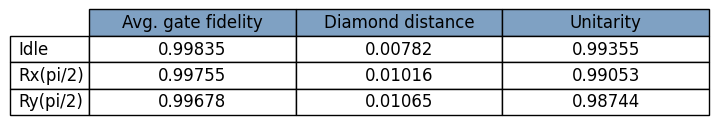

In [10]:
print(list(result.plots.keys()))
result.plot('layout_[0]_gate_metrics')

Alternatively, all plots (of all layouts) can be displayed via `result.plot_all()`.

## Creating a custom gate set

In this example we define a gate set ourselves as a list of quantum circuits. The example gate set chosen here is the "XYI" gate set with the addition of $\pi$-rotations around the X- and Y-axis. 
Note that we also increased the number of random GST sequences in the GST configuration from 50 to 100 to account for the larger gate set. 

In [11]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import CZGate, RGate

# Define a list of gate instructions
gate_list = [RGate(1e-10, 0), RGate(0.5 * np.pi, 0), RGate(0.5 * np.pi, np.pi / 2), RGate(np.pi, 0), RGate(np.pi, np.pi / 2)]
# Define the gate set as a list of circuits, each with one gate instruction
gate_set = [QuantumCircuit(1, 0) for _ in range(len(gate_list))]
for i, gate in enumerate(gate_list):
    gate_set[i].append(gate, [0])
# Define the gate names (to be used for indentification and in plots/tables)
gate_labels = ["Idle", "Rx(pi/2)", "Ry(pi/2)", "Rx(pi)", "Ry(pi)"]

# Checking the gate set for correctness
for gate in gate_set:
    print(gate)

   ┌────────┐
q: ┤ R(0,0) ├
   └────────┘
   ┌──────────┐
q: ┤ R(π/2,0) ├
   └──────────┘
   ┌────────────┐
q: ┤ R(π/2,π/2) ├
   └────────────┘
   ┌────────┐
q: ┤ R(π,0) ├
   └────────┘
   ┌──────────┐
q: ┤ R(π,π/2) ├
   └──────────┘


In [12]:
CUSTOM_1Q_GST = GSTConfiguration(
    qubit_layouts=[[0]],
    gate_set=gate_set,
    gate_labels = gate_labels,
    num_circuits=100,
    shots=1000,
    rank=4,
    verbose=True,
    bootstrap_samples=0,
)

In [13]:
benchmark = CompressiveGST(backend, CUSTOM_1Q_GST)
benchmark.run()
result = benchmark.analyze()

2024-12-02 14:27:30,722 - iqm.benchmarks.logging_config - INFO - Now generating 100 random GST circuits...
2024-12-02 14:27:31,004 - iqm.benchmarks.logging_config - INFO - Will transpile all 100 circuits according to fixed physical layout
2024-12-02 14:27:31,005 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2024-12-02 14:27:31,907 - iqm.benchmarks.logging_config - INFO - Submitting batch with 100 circuits corresponding to qubits [0]
2024-12-02 14:27:31,909 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2024-12-02 14:27:32,042 - iqm.benchmarks.logging_config - INFO - Retrieving all counts


Starting mGST optimization...
 10%|█████████▏                                                                                  | 10/100 [00:15<02:23,  1.59s/it]
	 Convergence criterion satisfied
	 Final objective 2.40e-4 in time 15.92s


#### Checking out the process matrix corresponding to the pi rotation around the y-axis

In [14]:
gauge_opt_gates = result.dataset.attrs[f"results_layout_{str([0])}"]["gauge_opt_gates"]
print(np.array_str(gauge_opt_gates[4], precision=3, suppress_small=True))

[[ 0.019+0.j    -0.001+0.001j -0.001-0.001j  0.997+0.j   ]
 [-0.004+0.002j  0.002-0.001j -0.987-0.008j -0.   +0.001j]
 [-0.004-0.002j -0.987+0.008j  0.002+0.001j -0.   -0.001j]
 [ 0.981+0.j     0.001-0.001j  0.001+0.001j  0.003+0.j   ]]


#### All plots for the custom gate set

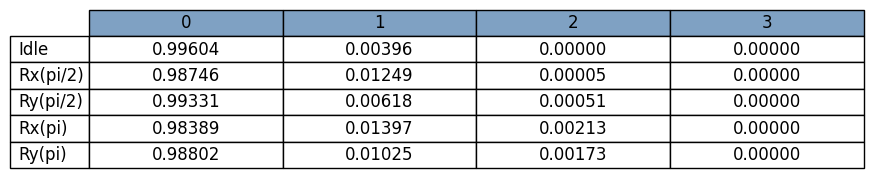

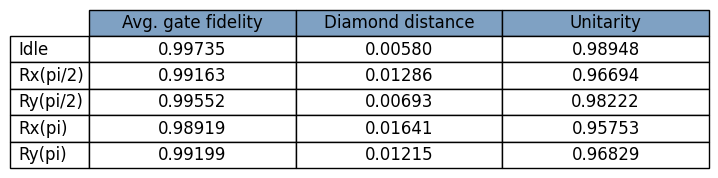

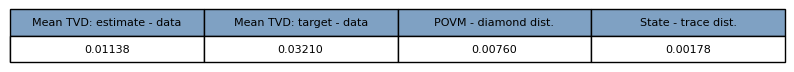

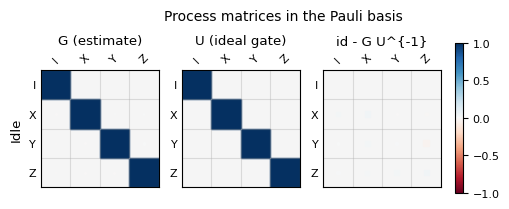

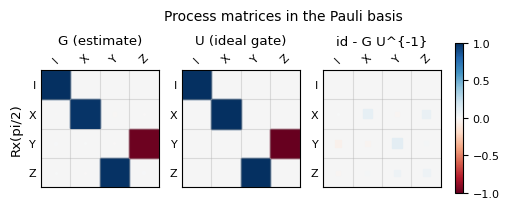

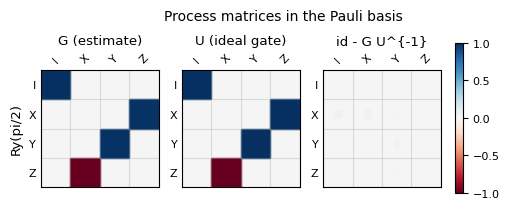

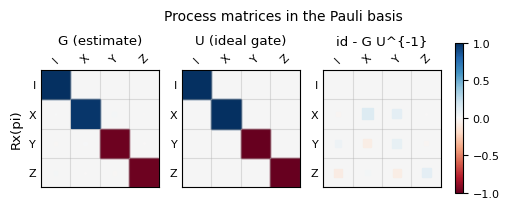

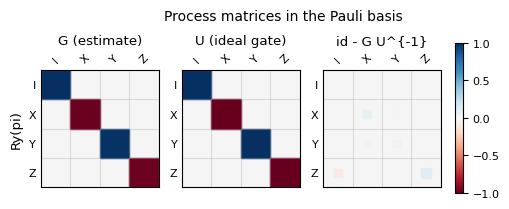

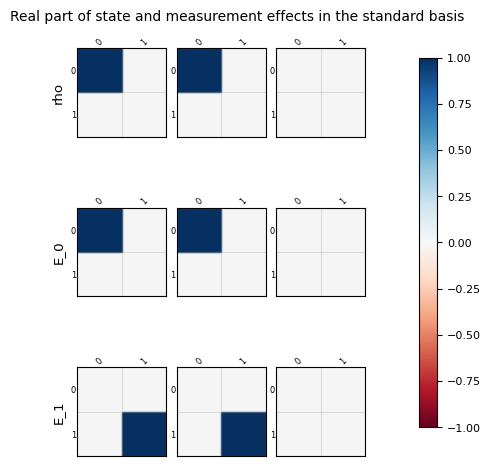

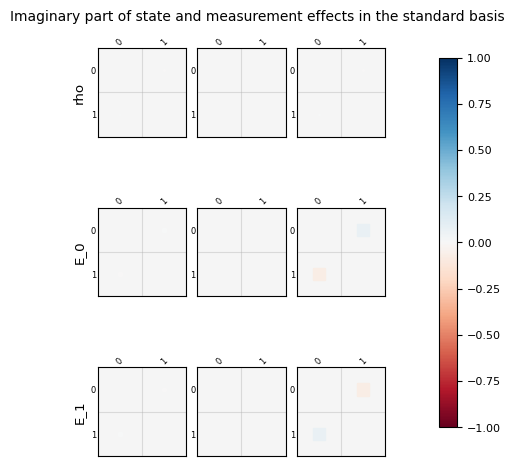

In [15]:
result.plot_all()